In [52]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
import string
from collections import OrderedDict
from gensim import corpora, models, similarities
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt


class LDAHelper:
    """
    Current LDAHelper implementation within pipeline
    """
    def __init__(self):
        self.version = 0
        self.stopwords = [
            'RT',
            'rt'
        ] + stopwords.words('english') + list(string.punctuation)

    def clean_up(self, word):
        """
        Clean up punctuation.
        Lower case string.
        :param word: full length tweet
        :return: Cleaned up tweet
        """
        return word.translate(None, string.punctuation)

    def lemmatize_stemming(self, word_without_punctuation):
        """
        Lemmatize and stemming a word
        :param word_without_punctuation:
        :return: resulting word
        """
        stemmer = SnowballStemmer('english')
        return stemmer.stem(WordNetLemmatizer().lemmatize(word_without_punctuation, pos='v'))
    
    def valid(self, word):
        """
        Verify the validity of a word.
        :param word: word in a tweet
        :return: True if the word passes a set of rules. To be formalized later
        """
        return word not in self.stopwords and word[:1] != '@' and word[:4] != 'http'

    def preprocess(self, tweet):
        """
        Applying lemmatization and stemming to any word that is not part of
        our stopwords
        :param tweet: Full tweet
        :return: Array of processed words
        """
        return [self.lemmatize_stemming(word)
                for word in gensim.utils.simple_preprocess(tweet, min_len=3)
                if self.valid(word)]
    
    def preprocess_without_LS(self, tweet):
        """
        Pre processing without lemmatization and stemming to test results 
        from this paper http://www.cs.cornell.edu/~xanda/winlp2017.pdf?fbclid=IwAR1v1kud8O551DJysvtuU2UC0Ra-oAAPLban_ZiKfyvN58_aWCjZUdjMQeM
        :param tweet: Full tweet
        :return: Array of processed words
        """
        return [word
                for word in gensim.utils.simple_preprocess(tweet, min_len=3)
                if self.valid(word)]
    

In [53]:
l = LDAHelper()
l.preprocess('So good to see that Republicans will be winning the Great State of Alabama Senate Seat back, now that lightweight Senator @DougJones cast a partisan vote for the Impeachment Hoax. Thought his boss, Cryin’ Chuck, would have forced him to vote against the Hoax. A Do Nothing Stiff!')

[u'good',
 u'see',
 u'republican',
 u'win',
 u'great',
 u'state',
 u'alabama',
 u'senat',
 u'seat',
 u'back',
 u'lightweight',
 u'senat',
 u'dougjon',
 u'cast',
 u'partisan',
 u'vote',
 u'impeach',
 u'hoax',
 u'think',
 u'boss',
 u'cryin',
 u'chuck',
 u'would',
 u'forc',
 u'vote',
 u'hoax',
 u'noth',
 u'stiff']

### PROOF OF CONCEPT
Experiment is ran on 1.6 million english tweets from users across the world. No specific topics are expected

In [54]:
# Load dataset
dataset = './training_set.csv'
tweets = pd.read_csv(dataset, encoding='latin1')
tweets = tweets['Tweet']
tweets.head(5)

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
0    is upset that he can't update his Facebook by ...
0    @Kenichan I dived many times for the ball. Man...
0      my whole body feels itchy and like its on fire 
0    @nationwideclass no, it's not behaving at all....
Name: Tweet, dtype: object

In [55]:
# Preprocessing all tweets
# 1. Separating a tweet into array of words
# 2. Lemmatization and stemming
# 3. Removing all stopwords, @Username, links and words of length less than 2
corpus = []
for tweet in tweets:
    corpus.append(l.preprocess_without_LS(tweet))

corpus[0:10]

[[u'switchfoot',
  u'twitpic',
  u'com',
  u'awww',
  u'bummer',
  u'shoulda',
  u'got',
  u'david',
  u'carr',
  u'third',
  u'day'],
 [u'upset',
  u'update',
  u'facebook',
  u'texting',
  u'might',
  u'cry',
  u'result',
  u'school',
  u'today',
  u'also',
  u'blah'],
 [u'kenichan',
  u'dived',
  u'many',
  u'times',
  u'ball',
  u'managed',
  u'save',
  u'rest',
  u'bounds'],
 [u'whole', u'body', u'feels', u'itchy', u'like', u'fire'],
 [u'nationwideclass', u'behaving', u'mad', u'see'],
 [u'kwesidei', u'whole', u'crew'],
 [u'need', u'hug'],
 [u'loltrish',
  u'hey',
  u'long',
  u'time',
  u'see',
  u'yes',
  u'rains',
  u'bit',
  u'bit',
  u'lol',
  u'fine',
  u'thanks'],
 [u'tatiana_k', u'nope'],
 [u'twittera', u'que', u'muera']]

In [56]:
# 1. Transforming corpus into Dictionary (mapping of normalized words to integer ID)
# 2. Transforming each tweet into bag of words (Mapping of word to its occurence in tweet)
# 3. TDIDF (term frequency-inverse document frequency) Model created
dictionary = corpora.Dictionary(corpus)
bow_corpus = [dictionary.doc2bow(text) for text in corpus]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [62]:
# LDA Model created
total_topics = 5
lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

In [63]:
lda.show_topics(total_topics, 5)

[(0,
  u'0.056*"com" + 0.022*"twitpic" + 0.016*"www" + 0.013*"new" + 0.010*"summer"'),
 (1,
  u'0.033*"quot" + 0.017*"thanks" + 0.014*"lol" + 0.013*"twitter" + 0.011*"thank"'),
 (2,
  u'0.012*"looking" + 0.010*"working" + 0.010*"better" + 0.009*"weekend" + 0.009*"pay"'),
 (3,
  u'0.025*"love" + 0.018*"know" + 0.015*"like" + 0.012*"see" + 0.010*"really"'),
 (4,
  u'0.039*"day" + 0.035*"good" + 0.023*"today" + 0.018*"get" + 0.018*"morning"')]

In [64]:
# Save our model - Eventually to EC2 Instance
from gensim.test.utils import datapath

temp_file = datapath("general_tweets_NO_LS_model")
lda.save(temp_file)

In [65]:
# Show mapping of words to topics
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

,amazing,amp,awesome,back,bed,best,better,bit,blog,check,...,watching,week,weekend,well,win,work,working,would,www,yes
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005672,0.000000,0.009661,...,0.005979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016244,0.000000
1,0.000000,0.004979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.005659,0.000000,0.000000,0.000000,0.005638,0.000000,0.009227
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009775,0.000000,0.005966,0.000000,...,0.000000,0.000000,0.009335,0.000000,0.004546,0.000000,0.010135,0.000000,0.000000,0.000000
3,0.005922,0.008116,0.008947,0.005911,0.000000,0.006124,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.011432,0.007557,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.007108,0.000000,0.007262,0.000000,0.016908,0.000000,0.000000,0.000000,0.000000


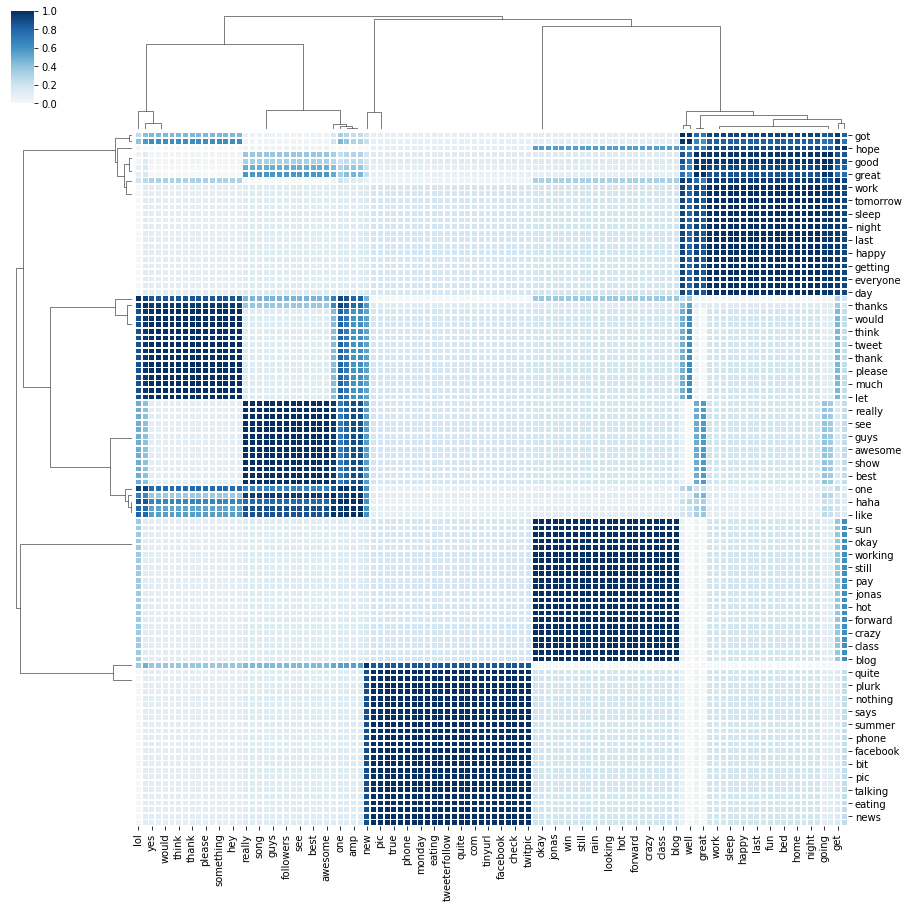

In [66]:
g=sns.clustermap(df_lda.corr(), 
                 center=0, 
                 standard_scale=1, 
                 cmap="RdBu", 
                 metric='cosine', 
                 linewidths=.75, 
                 figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

### EXPERIMENT ON HISTORICAL DONALD TRUMP TWEETS

In [71]:
dataset = './donald_trump_tweets.csv'
tweets = pd.read_csv(dataset, encoding='latin1')
tweets.head(5)

,text
0,RT @realDonaldTrump: MAKE AMERICA GREAT AGAIN ...
1,RT @realDonaldTrump: DRAIN THE SWAMP!
2,RT @Jim_Jordan: President Trumpâs budget set...
3,RT @realDonaldTrump: 95% Approval Rating in th...
4,RT @realDonaldTrump: Wall Street Journal Edito...


In [85]:
corpus_DT = []
for tweet in tweets['text']:
    corpus_DT.append(l.preprocess_without_LS(tweet))

corpus_DT[0:10]

[[u'realdonaldtrump',
  u'make',
  u'america',
  u'great',
  u'keep',
  u'america',
  u'great'],
 [u'realdonaldtrump', u'drain', u'swamp'],
 [u'jim_jordan',
  u'president',
  u'trump\xe2',
  u'budget',
  u'sets',
  u'right',
  u'priorities',
  u'funds',
  u'wall',
  u'supports',
  u'military',
  u'cuts',
  u'wasteful',
  u'foreign',
  u'aid',
  u'ena\xe2'],
 [u'realdonaldtrump',
  u'approval',
  u'rating',
  u'republican',
  u'party',
  u'record',
  u'overall',
  u'plus',
  u'add',
  u'points',
  u'corrupt',
  u'democrat',
  u'politicians\xe2'],
 [u'realdonaldtrump',
  u'wall',
  u'street',
  u'journal',
  u'editorial',
  u'crazy',
  u'nancy',
  u'aimed',
  u'trump',
  u'hit',
  u'uncle',
  u'joe'],
 [u'realdonaldtrump',
  u'lot',
  u'people',
  u'feel',
  u'defeated',
  u'trump',
  u'always',
  u'wins',
  u'seems',
  u'like',
  u'nothing',
  u'stop',
  u'danny',
  u'villazon',
  u'nytimes',
  u'dan\xe2'],
 [u'realdonaldtrump', u'thank', u'new', u'hampshire', u'dvzq', u'upjhi'],
 [u're

In [86]:
dictionary = corpora.Dictionary(corpus_DT)
bow_corpus = [dictionary.doc2bow(text) for text in corpus_DT]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [87]:
total_topics = 5
lda = models.LdaModel(bow_corpus, 
                      id2word=dictionary, 
                      num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

In [88]:
lda.show_topics(total_topics,10)

[(0,
  u'0.038*"barackobama" + 0.015*"obama" + 0.010*"deal" + 0.010*"china" + 0.008*"realdonaldtrump" + 0.008*"trump" + 0.007*"amp" + 0.005*"like" + 0.005*"people" + 0.005*"must"'),
 (1,
  u'0.028*"trump" + 0.018*"apprentice" + 0.017*"bit" + 0.014*"donald" + 0.010*"obamacare" + 0.010*"via" + 0.010*"miss" + 0.009*"realdonaldtrump" + 0.008*"celebrity" + 0.007*"success"'),
 (2,
  u'0.014*"mittromney" + 0.013*"golf" + 0.012*"nbc" + 0.010*"interview" + 0.009*"cont" + 0.009*"discussing" + 0.008*"china" + 0.008*"amp" + 0.007*"good" + 0.006*"great"'),
 (3,
  u'0.034*"great" + 0.025*"realdonaldtrump" + 0.013*"trump" + 0.012*"america" + 0.011*"thank" + 0.008*"make" + 0.008*"need" + 0.007*"get" + 0.007*"time" + 0.006*"amp"'),
 (4,
  u'0.033*"thanks" + 0.030*"realdonaldtrump" + 0.018*"trump" + 0.011*"cont" + 0.010*"new" + 0.008*"president" + 0.007*"donald" + 0.007*"great" + 0.007*"would" + 0.006*"debt"')]

In [89]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

,amazing,america,amp,apprentice,art,bad,barackobama,best,big,bit,...,tonight,tower,true,trump,trumpvlog,via,vote,watch,work,would
0,0.000000,0.00000,0.006677,0.000000,0.00478,0.003543,0.037564,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.008259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.00000,0.005584,0.017923,0.00000,0.000000,0.000000,0.000000,0.000000,0.016591,...,0.000000,0.007269,0.000000,0.028146,0.006805,0.010143,0.000000,0.003513,0.000000,0.000000
2,0.000000,0.00000,0.007658,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005107,0.000000,0.000000
3,0.004995,0.01193,0.006334,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004322,0.000000,0.000000,0.012755,0.000000,0.000000,0.005517,0.000000,0.005837,0.000000
4,0.000000,0.00000,0.004335,0.000000,0.00000,0.000000,0.000000,0.004368,0.003617,0.000000,...,0.003701,0.000000,0.005636,0.017811,0.000000,0.000000,0.000000,0.000000,0.000000,0.006873


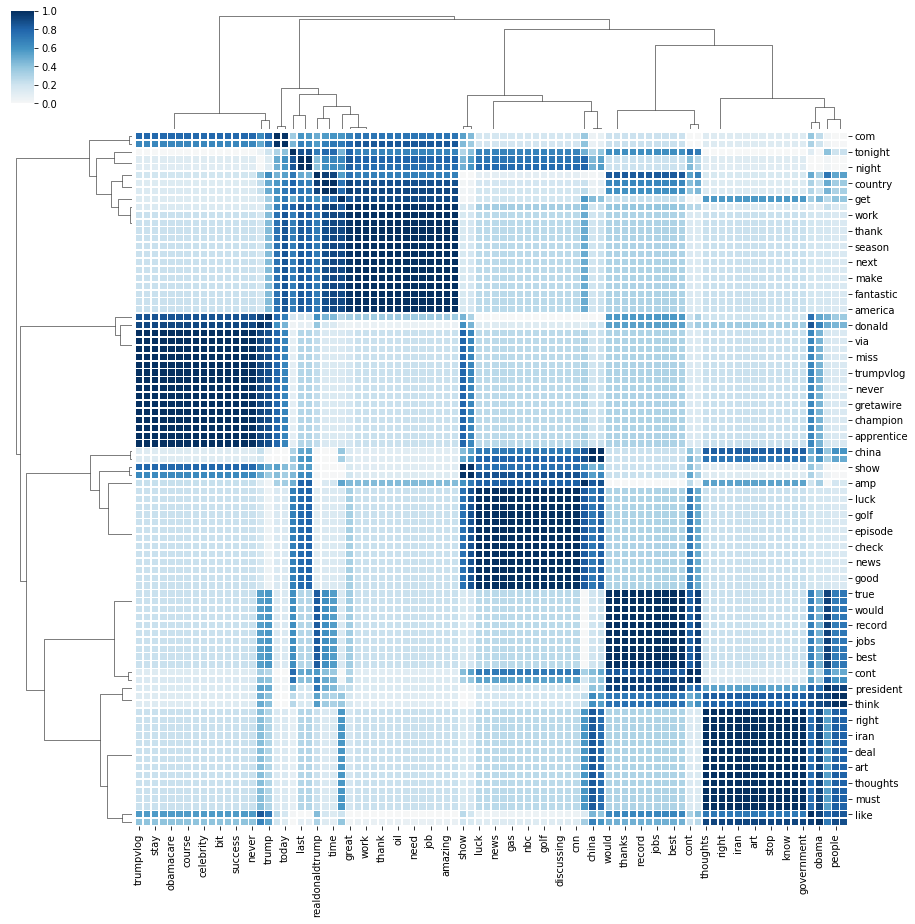

In [90]:
g=sns.clustermap(df_lda.corr(), 
                 center=0, 
                 standard_scale=1, 
                 cmap="RdBu", 
                 metric='cosine', 
                 linewidths=.75, 
                 figsize=(15, 15))

plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [105]:
# Let's try to predict one tweet for DT
unseen_tweets = [
'So good to see that Republicans will be winning the Great State of Alabama Senate Seat back, now that lightweight Senator @DougJones cast a partisan vote for the Impeachment Hoax. Thought his boss, Cryin’ Chuck, would have forced him to vote against the Hoax. A Do Nothing Stiff!',
'Tune in the apprentice tonight and see which the celebrity wins our TV show!',
'MAKE AMERICA GREAT AGAIN!' ]
corpus_exp = [l.preprocess_without_LS(tweet) for tweet in unseen_tweets]
bow_corpus = [dictionary.doc2bow(text) for text in corpus_exp]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
unseen_corpus_lda = lda[corpus_tfidf[1]]
unseen_corpus_lda

[(0, 0.0560716),
 (1, 0.33664495),
 (2, 0.056773387),
 (3, 0.49311206),
 (4, 0.057398032)]